In [1]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

     |████████████████████████████████| 320.4MB 49kB/s 
     |████████████████████████████████| 460kB 36.2MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 358kB 2.8MB/s 


In [2]:
!pip install pycocotools

In [3]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2760, done.
remote: Counting objects: 100% (2760/2760), done.
remote: Compressing objects: 100% (2427/2427), done.
remote: Total 2760 (delta 526), reused 1404 (delta 297), pack-reused 0
Receiving objects: 100% (2760/2760), 57.72 MiB | 33.89 MiB/s, done.
Resolving deltas: 100% (526/526), done.


In [4]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [5]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1294609 sha256=280118354761aa41af9d595008442d940559a88374c597dc5043dfa651367f17
  Stored in directory: /tmp/pip-ephem-wheel-cache-v1bg7v9x/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


In [6]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [7]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [8]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [9]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [10]:

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [11]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

In [12]:
model_name = 'ssd_mobilenet_v2_coco_2018_03_29'
detection_model = load_model(model_name)

187932672/187925923 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [14]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [ ]:
detection_model.output_shapes

In [18]:
import time

def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  start_time = time.time()
  # Run inference
  output_dict = model(input_tensor)

  end_time = time.time() - start_time
  print("Inference time: ", end_time * 1000)
  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [16]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

Inference time:  146.67057991027832


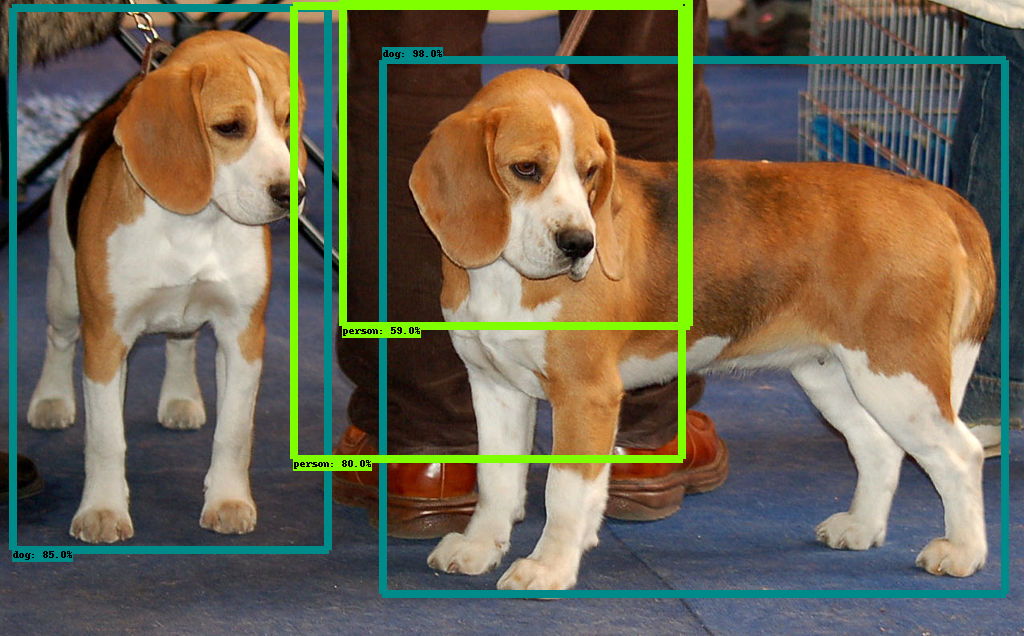

Inference time:  192.87657737731934


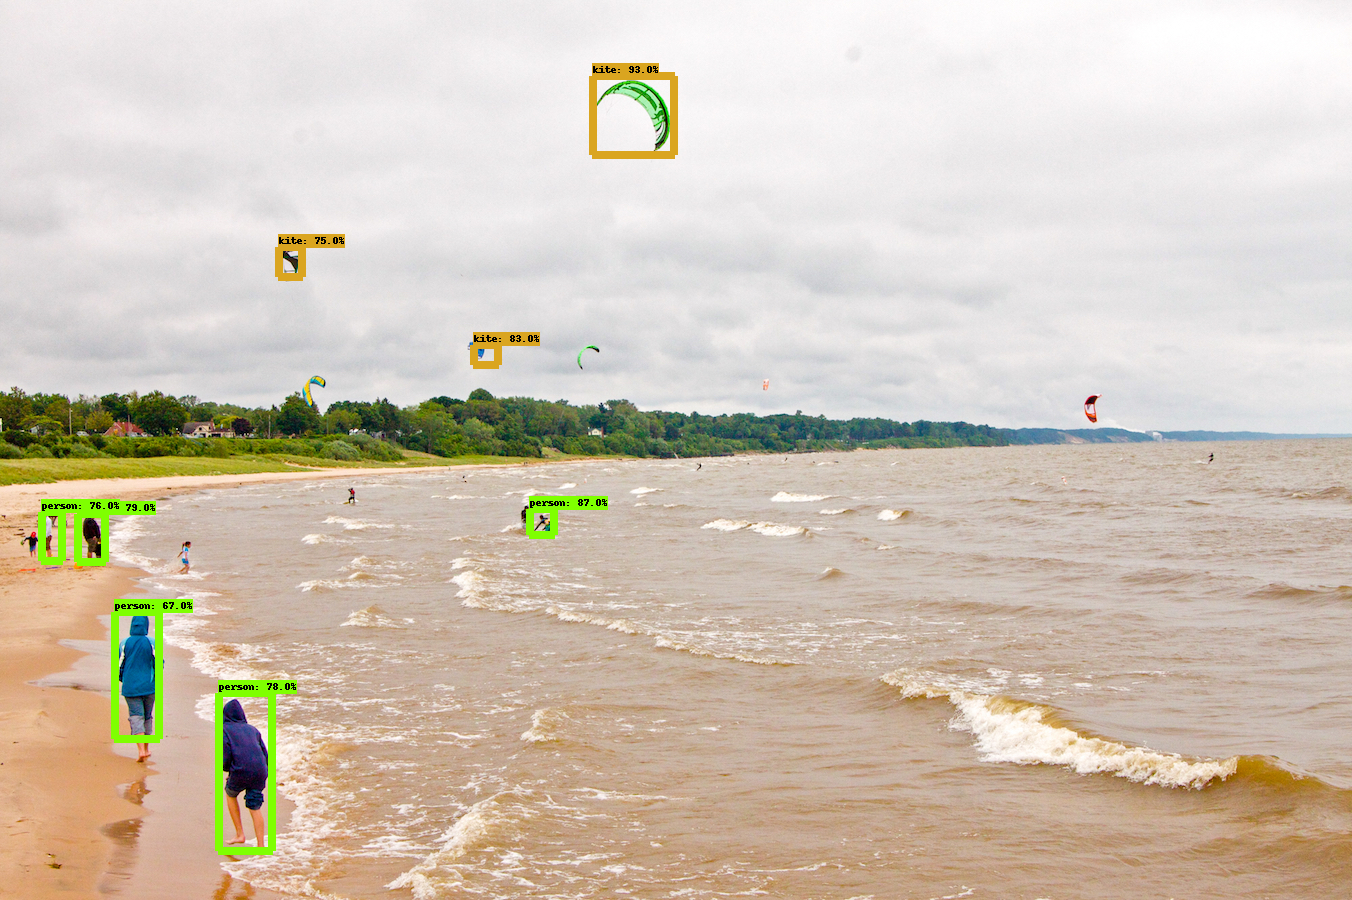

In [19]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

In [20]:
model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
detection_model = load_model(model_name)

149127168/149119618 [==============================] - 2s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Inference time:  5521.933317184448


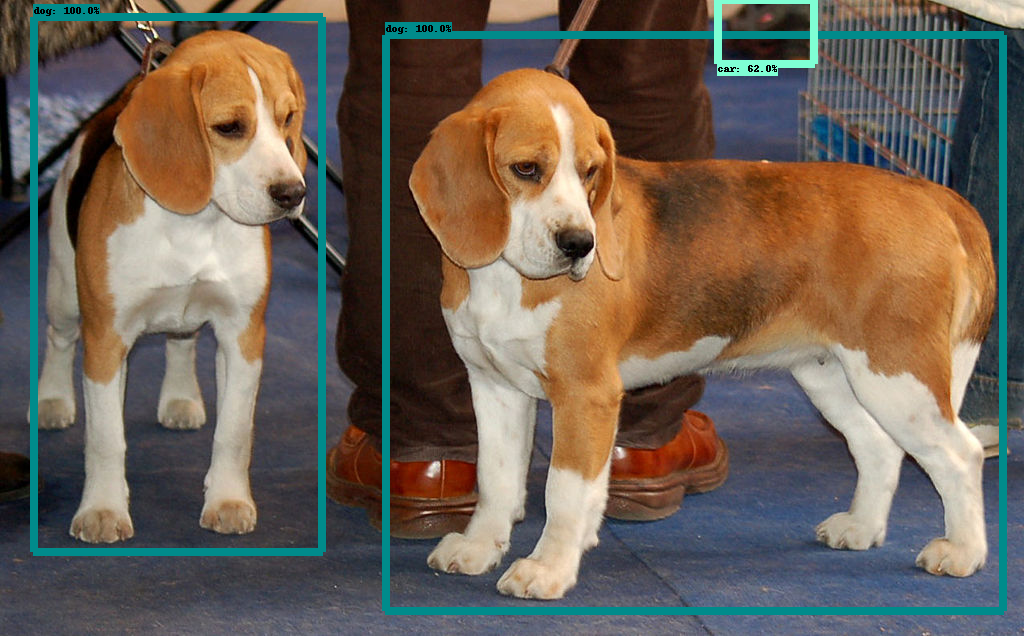

Inference time:  1496.825933456421


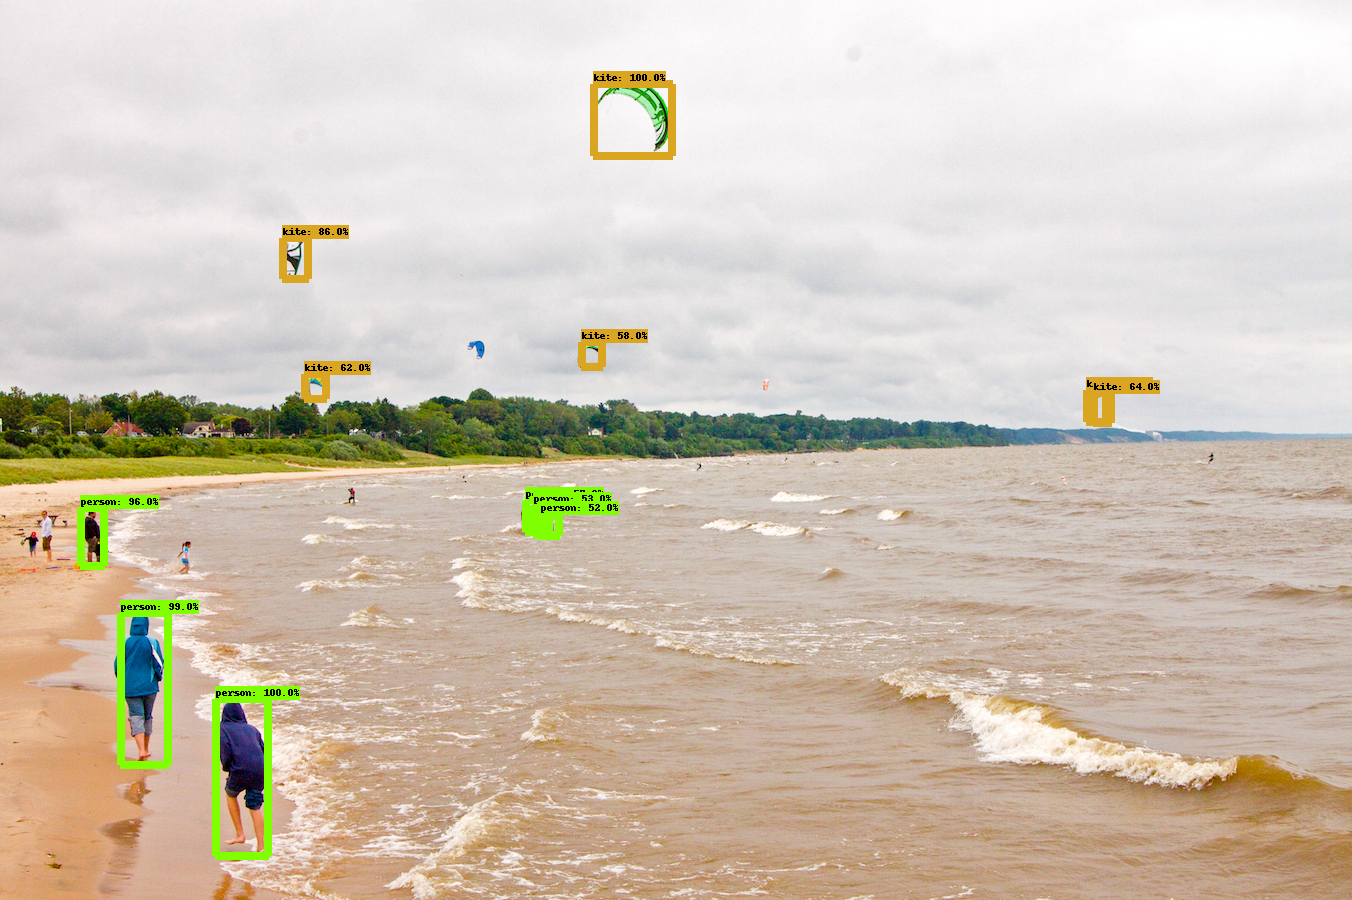

In [21]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)